# NBA Moneyline Betting Model
Binary classification using logistic regression to predict whether the favored team covers the moneyline.  
Dataset: ~17 years of historical NBA betting lines.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Data Preprocessing
- regular: 1 if regular season game, 0 if playoff
- whos_favored: 1 if home team is favored, 0 if away team is favored
- moneyline_hit: 1 if the favored team won (moneyline bet succeeded), 0 otherwise

In [4]:
df = pd.read_csv("/content/drive/MyDrive/nba_betting_data.csv")

# Encode categorical columns
df['regular'] = (df['regular'] == True).astype(int)
df['whos_favored'] = (df['whos_favored'] == 'home').astype(int)

# Drop rows with missing pre-game betting data
df.dropna(subset=['spread', 'moneyline_away', 'moneyline_home'], inplace=True)

# moneyline_hit = 1 if the favored team won
df['moneyline_hit'] = (
    ((df['whos_favored'] == 1) & (df['score_home'] > df['score_away'])) |
    ((df['whos_favored'] == 0) & (df['score_away'] > df['score_home']))
).astype(int)

df.head()

,regular,score_away,score_home,whos_favored,spread,total,moneyline_away,moneyline_home,id_spread,moneyline_hit
0,1,105,103,0,2.0,187.5,-130.0,110.0,2.0,1
1,1,84,82,0,2.0,184.5,-130.0,110.0,2.0,1
2,1,105,108,1,3.0,215.5,135.0,-155.0,2.0,1
3,1,85,93,1,8.0,205.5,290.0,-350.0,2.0,1
4,1,105,112,1,7.0,205.0,255.0,-305.0,2.0,1


In [8]:
print(f"Total games : {len(df):,}")
print(f"Moneyline hit rate (baseline) : {df['moneyline_hit'].mean():.2%}")

Total games : 19,817
Moneyline hit rate (baseline) : 68.35%


## Exploratory Data Analysis (EDA)

In [10]:
reg_rate  = df[df['regular'] == 1]['moneyline_hit'].mean()
play_rate = df[df['regular'] == 0]['moneyline_hit'].mean()

print(f"Favorite win rate — Regular Season: {reg_rate:.2%}")
print(f"Favorite win rate — Playoffs: {play_rate:.2%}")

# Win rate by home/away favored
home_fav_rate = df[df['whos_favored'] == 1]['moneyline_hit'].mean()
away_fav_rate = df[df['whos_favored'] == 0]['moneyline_hit'].mean()
print(f"\nFavorite win rate — Home favored: {home_fav_rate:.2%}")
print(f"Favorite win rate — Away favored: {away_fav_rate:.2%}")

Favorite win rate — Regular Season: 68.36%
Favorite win rate — Playoffs: 68.19%

Favorite win rate — Home favored: 70.15%
Favorite win rate — Away favored: 64.67%


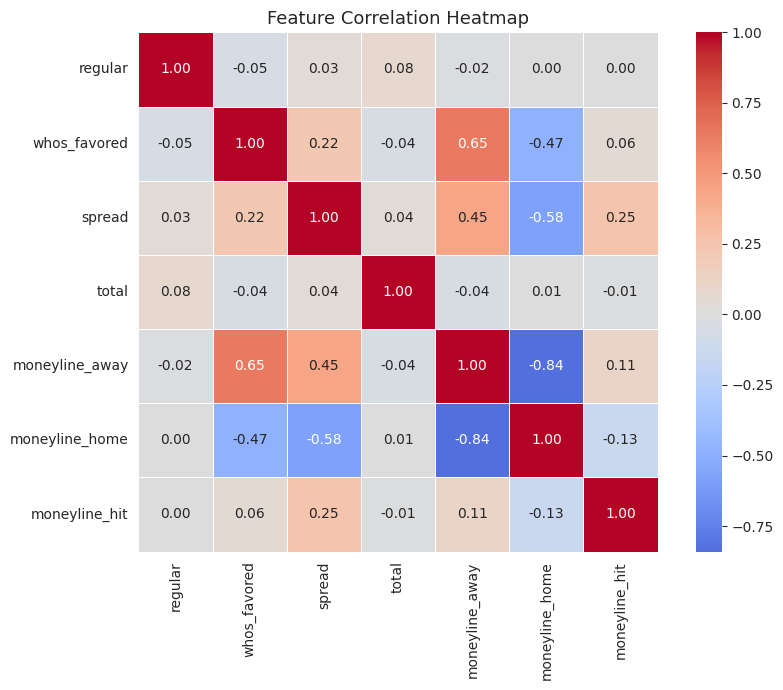

In [11]:
# correlation heatmap
numeric_cols = ['regular', 'whos_favored', 'spread', 'total',
                'moneyline_away', 'moneyline_home', 'moneyline_hit']

plt.figure(figsize=(9, 7))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=True, fmt='.2f', cmap='coolwarm', center=0,
    linewidths=0.5, square=True
)
plt.title('Feature Correlation Heatmap', fontsize=13)
plt.tight_layout()
plt.show()

## Feature Engineering
Deriving additional predictive features from the raw moneyline odds:
- implied_prob_fav: bookmaker-implied win probability for the favorite (converted from American odds)
- overround: bookmaker's margin (sum of implied probs minus 1)
- moneyline_diff: raw numerical gap between home and away lines

In [14]:
def american_to_implied_prob(odds_series):
    return np.where(
        odds_series > 0,
        100 / (odds_series + 100),
        np.abs(odds_series) / (np.abs(odds_series) + 100)
    )

# Implied probabilities for each side
df['implied_prob_home'] = american_to_implied_prob(df['moneyline_home'])
df['implied_prob_away'] = american_to_implied_prob(df['moneyline_away'])

# Implied probability specifically for the favored team
df['implied_prob_fav'] = np.where(
    df['whos_favored'] == 1,
    df['implied_prob_home'],
    df['implied_prob_away']
)

# Bookmaker overround (vig / juice)
df['overround'] = df['implied_prob_home'] + df['implied_prob_away'] - 1

# Raw moneyline differential
df['moneyline_diff'] = df['moneyline_home'] - df['moneyline_away']

df[['implied_prob_fav', 'overround', 'moneyline_diff']].describe()

,implied_prob_fav,overround,moneyline_diff
count,19817.000000,19817.000000,19817.000000
mean,0.711983,0.037658,-378.861129
std,0.119564,0.011948,1067.302885
min,0.294118,-0.039216,-17000.000000
25%,0.607843,0.033375,-620.000000
50%,0.705882,0.037594,-315.000000
75%,0.800000,0.041408,260.000000
max,0.992366,0.733333,11900.000000


## Train, Validation, Test Datasets
60% for training, 20% for validation, 20% for testing  

In [18]:
features = [
    'regular',
    'whos_favored',
    'spread',
    'total',
    'implied_prob_fav',
    'overround',
    'moneyline_diff'
]
target = 'moneyline_hit'

df_shuffled = df.sample(frac=1, random_state=17).reset_index(drop=True)
n = len(df_shuffled)

train_df = df_shuffled.iloc[:int(0.6 * n)]
valid_df = df_shuffled.iloc[int(0.6 * n):int(0.8 * n)]
test_df  = df_shuffled.iloc[int(0.8 * n):]

x_train, y_train = train_df[features].values, train_df[target].values
x_valid, y_valid = valid_df[features].values, valid_df[target].values
x_test,  y_test  = test_df[features].values,  test_df[target].values

# Standardize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test  = scaler.transform(x_test)

## Logistic Regression Model
Logistic regression is well-suited for binary classification tasks
It outputs a probability that the favorite wins, thresholded at 0.5 for the final prediction.

In [19]:
model = LogisticRegression(max_iter=1000, random_state=17)
model.fit(x_train, y_train)

val_acc = accuracy_score(y_valid, model.predict(x_valid))
print(f"Validation Accuracy: {val_acc:.2%}")

Validation Accuracy: 69.14%


In [21]:
y_pred = model.predict(x_test)
test_acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_acc:.2%}")
print(classification_report(y_test, y_pred, target_names=['Underdog Wins', 'Favorite Wins']))

Test Accuracy: 68.52%
               precision    recall  f1-score   support

Underdog Wins       0.51      0.06      0.10      1252
Favorite Wins       0.69      0.98      0.81      2712

     accuracy                           0.69      3964
    macro avg       0.60      0.52      0.46      3964
 weighted avg       0.64      0.69      0.59      3964



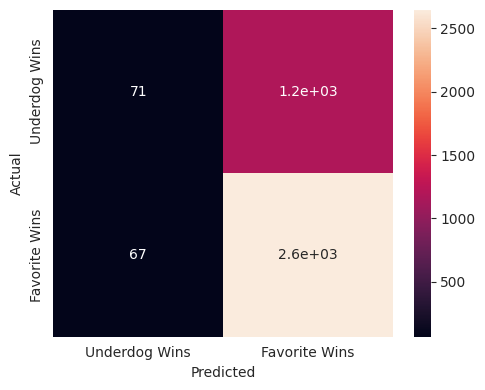

In [24]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True,
    xticklabels=['Underdog Wins', 'Favorite Wins'],
    yticklabels=['Underdog Wins', 'Favorite Wins']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()